# Preliminary operations

In [1]:
# General libraries
import pandas as pd
import numpy as np
import copy
import pickle
import os
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from math import sqrt
from scipy.ndimage import gaussian_filter1d

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, TimeDistributed
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

In [2]:
%run utils.ipynb

In [3]:
%run preprocessing.ipynb

In [4]:
%run preparation.ipynb

In [5]:
%run training_lstm.ipynb

In [6]:
%run predict.ipynb

In [7]:
# If set to true, the next cells will retrain the model on training data.
# Otherwise, prediction mode will be set.
to_train = False

# Loading data

In [8]:
# Read training data
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [9]:
df.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

In [10]:
# Save interactive html visualization for training data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal</sup>"
save_path = 'html_plots/normal.html'
fig = px.line(df[5400:-1800], x = df[5400:-1800].index, y = df[5400:-1800].columns, title = title) # Delete stabilization time
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

# Preprocessing

In [11]:
# List of parameters for preprocessing
params = [
    ['rides_not_served', 'active_customers', 'avg_actual_expected_price_60min', 'avg_actual_price_60min', 'rides_canceled', 'rides_rejections', 'rides_accepted', 'avg_actual_expected_price', 'avg_actual_price', 'avg_actual_expected_price_30min', 'avg_actual_price_30min', 'rides_requested'],
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    1, # differencing
    False, # seasonality
    True # normalize
]
scaler_path = f"df_{len(params[0])}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}_{params[9]}"

# Apply preprocessing strategy according to previous parameters selection
df_ = copy.deepcopy(df)
df_proc, scaler = preprocessing(df_,
                        columns_to_remove = params[0],
                        ratio = params[1],
                        smoothing = params[2],
                        collinearity = params[3],
                        log = params[4],
                        aggregation = params[5],
                        statistics = params[6],
                        differencing = params[7],
                        seasonality = params[8],
                        normalize = params[9],
                        load_scaler = False,        # Set to True only for test data, it will load the training scaler
                        save = True)                # Save dataset to datasets/proc

(86400, 28)


# Preparation

In [12]:
# Prepare training set for the model
train_set = preparation(df_proc,
                        window_size = 20,  # Windowing for LSTM model
                        overlap = 0,       # Number of observations to overlap for each window. MUST be < window size
                        val_hours = 0)     # Hours to consider for validation set. After cross-validation we use all training data

(4320, 20, 28)


# Modeling

In [13]:
# Training autoencoder model with normal data
if to_train:
    history, model = training_lstm(train_set,
                                   None,
                                   n_layers_encoder = 2,
                                   n_layers_decoder = 2,
                                   hidden_units = [128, 64, 32, 32, 64, 128],
                                   activation_hidden = 'tanh',
                                   activation_dense = 'sigmoid',
                                   dropout_rate = 0,
                                   learning_rate = 0.0001,
                                   n_epochs = 500,
                                   metric = 'mse',
                                   batch_size = 32,
                                   window_size = 20,
                                   plot = True,                                   # Save history of training loss
                                   save = True)                                   # Save model to models/lstm
    
    # Predict and assess performance on training set
    original, reconstructed = predict(model, train_set, scaler_path, recurrent = True)
    
    # Save metrics plots and dataframes
    num_features = min(train_set.shape[2], len(df_proc.columns))
    mae, mse, mape = save_predict_plots(original, reconstructed, df_proc.columns, num_features, scaler_path, model_type = 'lstm', plot = False, compute_df = True)

    # Plot training set reconstruction performance
    for column in range(0, len(df_proc.columns)):
        plt.figure(figsize = (10, 6))
        plt.plot(original[:, column], label = 'Original Features')
        plt.plot(reconstructed[:, column], label = 'Reconstructed Features', linestyle='--')
        plt.title(df_proc.columns[column])
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        
else:
    # Just load the model already trained. Be sure to enter the right path.
    model_path = 'models/lstm/2_2_128_128_tanh_sigmoid_0_00001_500_mse_32.pkl'
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

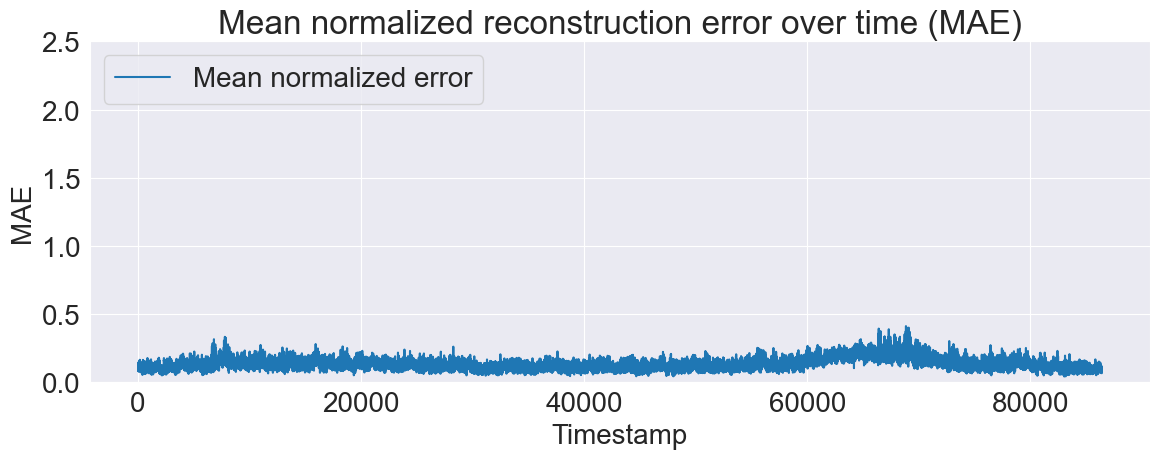

In [14]:
# Load metrics training dataset
mae_df = pd.read_csv("predictions/lstm/lstm_mae.csv")
mse_df = pd.read_csv("predictions/lstm/lstm_mse.csv")
mape_df = pd.read_csv("predictions/lstm/lstm_mape.csv")

# Compute mean mae and mse across columns on training set
mean_err_mae_norm = (mae_df - mae_df.min())/(mae_df.max() - mae_df.min())
mean_err_mae_norm = mean_err_mae_norm.mean(axis = 1)
#mean_err_mse = mse_df.mean(axis = 1)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams.update({'font.size': 20})
plt.plot(mean_err_mae_norm, label = 'Mean normalized error')
#plt.plot(mean_err_mse, color = 'b', label = 'MSE')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.ylim([0, 2.5])
plt.tight_layout()
plt.savefig('results/normal_MAE_lstm.png', dpi = 300)
plt.show()

# Compute failure

We compute the timestamp of the (possible) failure.

In [53]:
# Enter fail name and hour of the day (currently only "day", i.e., noon)
fail = 'driver_strike'
hour = 'day'

In [54]:
# Read event data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [55]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df_fail.columns:
    df_fail[column] = np.around(df_fail[column].astype(float), 5)
    df_fail[column] = df_fail[column].rolling(window = 300).mean()
df_fail = df_fail[6899:-1800].reset_index(drop = True)

In [56]:
# Define the values for x1, x2 and their corresponding y values
x1, y1 = 0, 0
x2, y2 = df['rides_requested'][6899:-1800].mean(), 1 # Scaling factor = 1 when rides requested >= mean
# Adjust  b to ensure the function is defined at x = 0
b = 0.1
# Values of ln(x+b) at x1 and x2
ln_x1_b = np.log(x1 + b)
ln_x2_b = np.log(x2 + b)
# System of equations:
# a * ln(0.1) + c = 0
# a * ln(df['rides_requested'].mean()) + c = 1
# We can represent this system as matrix equations A * [a, c] = Y
A = np.array([
    [ln_x1_b, 1],
    [ln_x2_b, 1]
])
Y = np.array([y1, y2])
# Solving for coefficients a and c
coefficients = np.linalg.solve(A, Y)
a, c = coefficients

In [57]:
# Computing index (also weighted)
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
factor = df['rides_requested'][6899:-1800].mean()
for column in df.columns:
    df[column] = np.around(df[column].astype(float), 5)
    df[column] = df[column].rolling(window = 300).mean()
df = df[6899:-1800].reset_index(drop = True)
failed_requests_train = [0] * len(df)
w_failed_requests_train = [0] * len(df)
for i in range(0, len(df)):
    failed_train, w_failed_train = compute_failed_requests(df['rides_not_served'][i], df['rides_requested'][i], factor, a, b, c)
    failed_requests_train[i] = failed_train
    w_failed_requests_train[i] = w_failed_train
combined_failed_requests_train = pd.Series(failed_requests_train)
w_combined_failed_requests_train = pd.Series(w_failed_requests_train)
failed_requests_fail = [0] * len(df_fail)
w_failed_requests_fail = [0] * len(df_fail)
factor = df['rides_requested'].mean()
for i in range(0, len(df_fail)):
    failed, w_failed = compute_failed_requests(df_fail['rides_not_served'][i], df_fail['rides_requested'][i], factor, a, b, c)
    failed_requests_fail[i] = failed
    w_failed_requests_fail[i] = w_failed

In [58]:
# By calling the function compute_thresholds, the code automatically compute the following thresholds.
perc_95, perc_97, perc_99 = compute_thresholds(combined_failed_requests_train, weight = False)
w_perc_95, w_perc_97, w_perc_99_t = compute_thresholds(w_combined_failed_requests_train, weight = True)

# Computing timestamps exceeding the thresholds
combined_failed_requests = pd.Series(failed_requests_fail)
w_combined_failed_requests = pd.Series(w_failed_requests_fail)
exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
w_exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
# Need to define interval sliding window where to look for exceeding timestamps, and % of exceeding timestamps needed to call a failure.
exceed_timestamps = exceed_thresholds(combined_failed_requests, exceed_timestamps, 1800, 0.95, perc_95, perc_97, perc_99)
w_exceed_timestamps = exceed_thresholds(w_combined_failed_requests, w_exceed_timestamps, 1800, 0.95, w_perc_95, w_perc_97, w_perc_99_t)

In [59]:
w_exceed_timestamps

{'perc_95': 0, 'perc_97': 0, 'perc_99': 0}

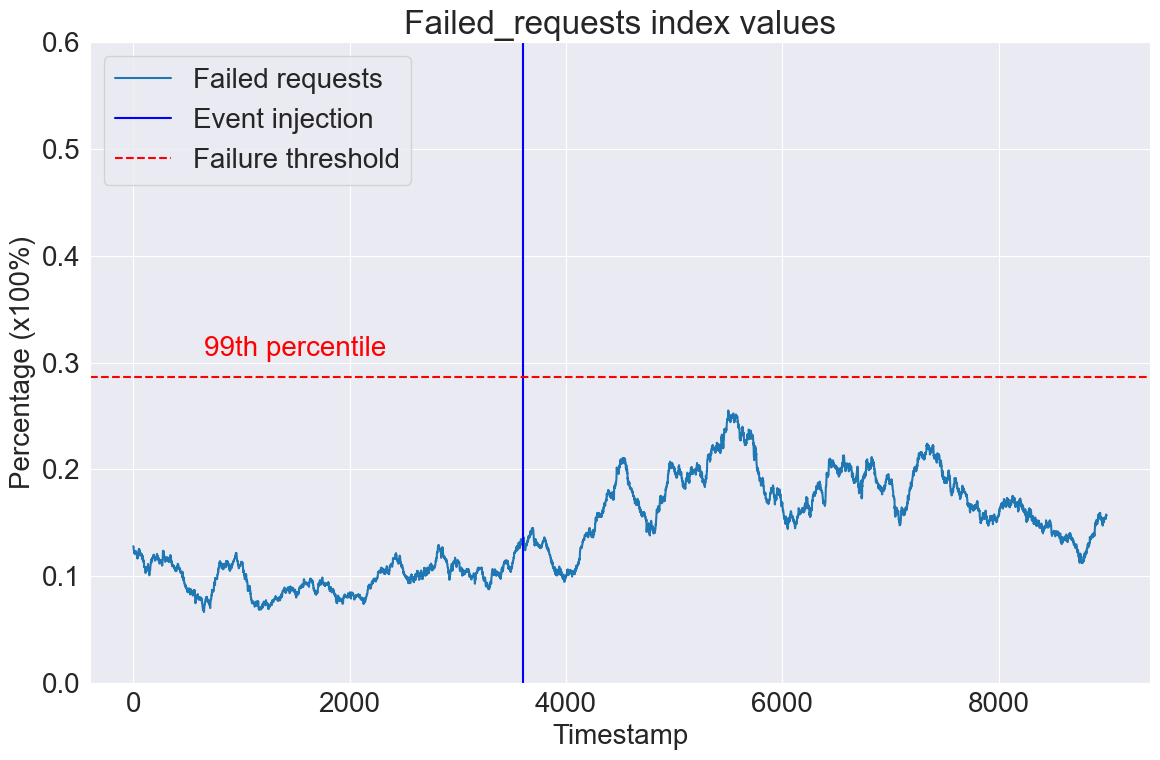

In [60]:
# Plot failed_requests index

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 20})

perc_95 = exceed_timestamps.get('perc_95', 0)
perc_97 = exceed_timestamps.get('perc_97', 0)
perc_99 = exceed_timestamps.get('perc_99', 0)
w_perc_95 = w_exceed_timestamps.get('perc_95', 0)
w_perc_97 = w_exceed_timestamps.get('perc_97', 0)
w_perc_99 = w_exceed_timestamps.get('perc_99', 0)
#plt.plot(combined_failed_requests, color = 'b')
w_combined_failed_requests = w_combined_failed_requests[:9000]
if 'greedy' in fail and fail != 'progressive_greedy':
    x_range = np.arange(len(w_combined_failed_requests))
    masked_failed_requests = np.where(x_range <= w_perc_99, w_combined_failed_requests, np.nan)
    plt.plot(x_range, masked_failed_requests, label='Failed requests')
else:
    plt.plot(w_combined_failed_requests, label='Failed requests')
plt.title('Failed_requests index values')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = w_perc_99_t, color = 'red', linestyle='--', label = 'Failure threshold')
plt.annotate(f'99th percentile', xy = (1500, w_perc_99_t),
             xytext = (1500, w_perc_99_t + 0.02),
             horizontalalignment = 'center', color = 'r')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='SES failure')
#max_value = combined_failed_requests.max()
#plt.axhline(y = max_value, color = 'b', linestyle = '--')
#plt.annotate(f'Max value: {max_value:.2f}', xy = (combined_failed_requests.idxmax(), max_value),
#             xytext = (combined_failed_requests.idxmax() + 300, max_value + 0.05),
#             horizontalalignment = 'right', color = 'b')
# max_value_w = w_combined_failed_requests.max()
# plt.axhline(y = max_value_w, color = 'r', linestyle = '--')
# plt.annotate(f'Max value: {max_value_w:.2f}', xy = (w_combined_failed_requests.idxmax(), max_value_w),
#              xytext = (w_combined_failed_requests.idxmax(), max_value_w + 0.05),
#              horizontalalignment = 'center', color = 'r')
plt.ylim(0, 0.6)
plt.xlim(-400, 9400)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/' + fail + '_' + hour + '.png', dpi = 300)
plt.show()

# Predicting

In [61]:
# Read test data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [62]:
# Save interactive html visualization for test data
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: {fail}, Hour: {hour}</sup>"
save_path = 'html_plots/' + fail + '_' + hour + '.html'
fig = px.line(df_fail[5400:-1800], x = df_fail[5400:-1800].index, y = df_fail[5400:-1800].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [63]:
df_fail_ = copy.deepcopy(df_fail)
# Apply preprocessing strategy according to previous parameters selection
df_proc_fail, scaler_ = preprocessing(df_fail_,
                               columns_to_remove = params[0],
                               ratio = params[1],
                               smoothing = params[2],
                               collinearity = params[3],
                               log = params[4],
                               aggregation = params[5],
                               statistics = params[6],
                               differencing = params[7],
                               seasonality = params[8],
                               normalize = params[9],
                               load_scaler = True,
                               save = False)

(10800, 28)


In [64]:
# Prepare test set for the model
test_set_fail = preparation(df_proc_fail,
                            window_size = 20,
                            overlap = 0,
                            val_hours = 0)

(540, 20, 28)


17/17 [==============================] - 0s 15ms/step
Mean MAE: 0        0.006612
1        0.007964
2        0.009404
3        0.008791
4        0.008454
           ...   
10795    0.019824
10796     0.01984
10797    0.020174
10798    0.019877
10799    0.019553
Length: 10800, dtype: object
Mean MSE: 0        0.000255
1        0.000478
2        0.000616
3        0.000594
4        0.000614
           ...   
10795    0.001784
10796    0.001874
10797    0.001847
10798     0.00188
10799    0.001893
Length: 10800, dtype: object
Mean MAPE: 0        0.301416
1        0.310057
2        0.322406
3        0.516192
4        0.507711
           ...   
10795    1.606968
10796    1.200402
10797    1.325218
10798    1.203026
10799    1.197288
Length: 10800, dtype: object


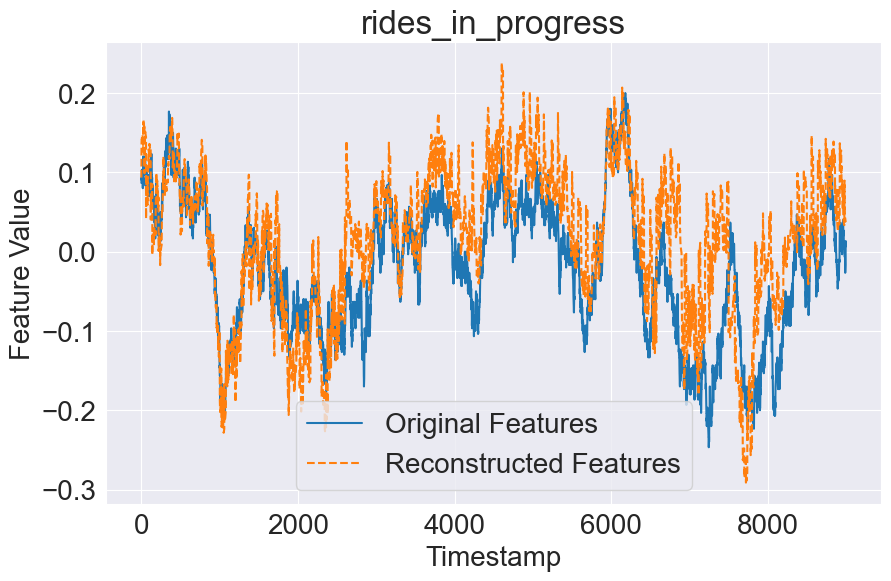

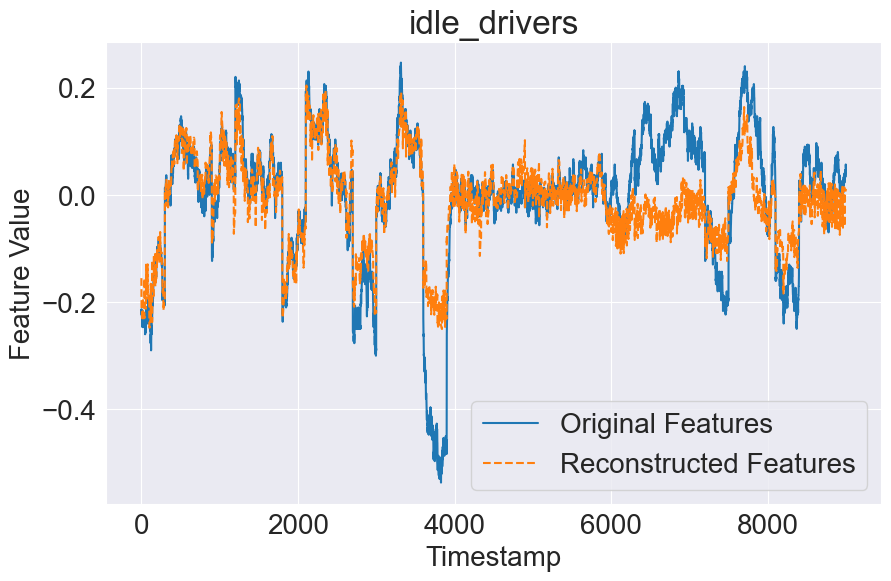

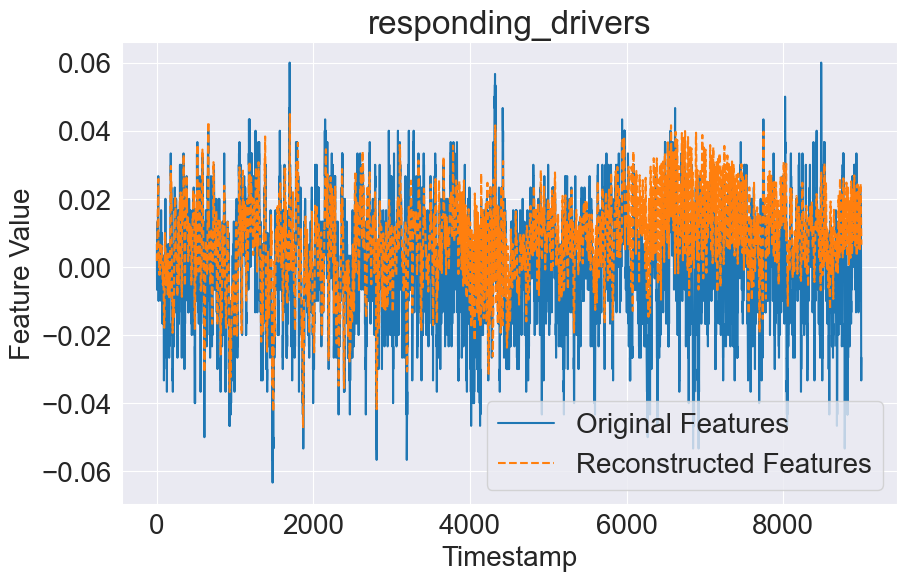

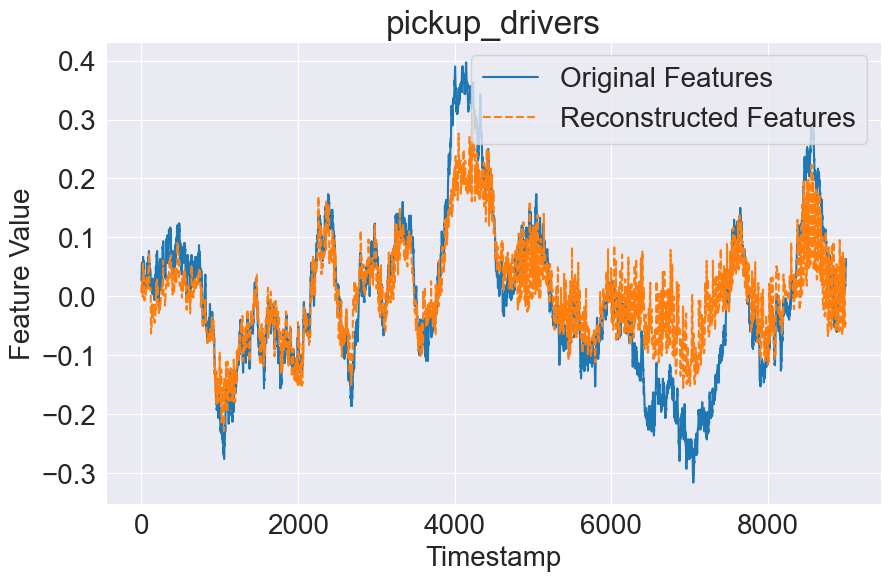

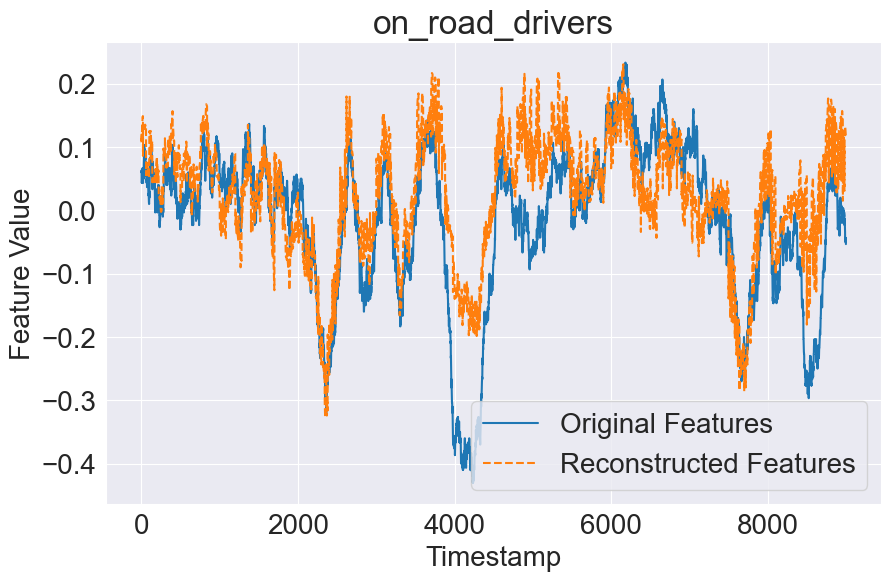

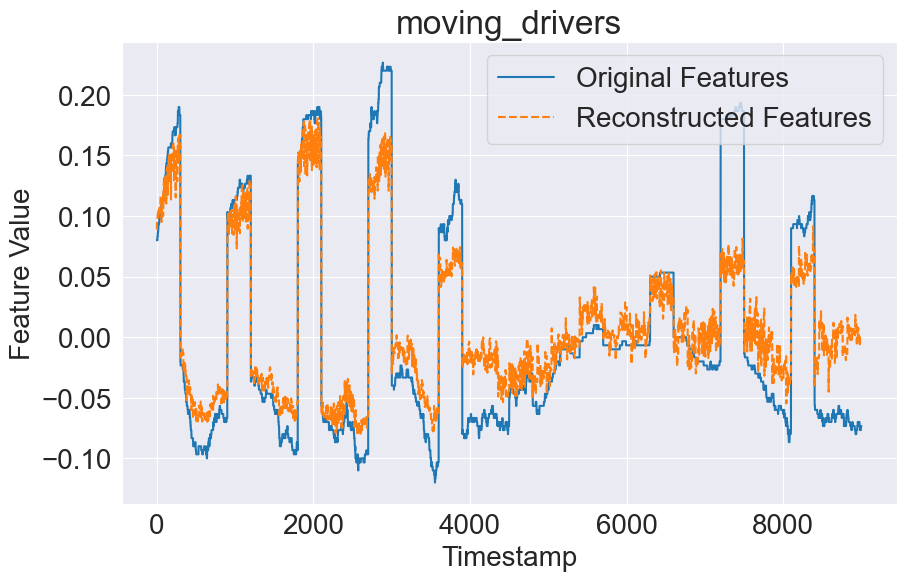

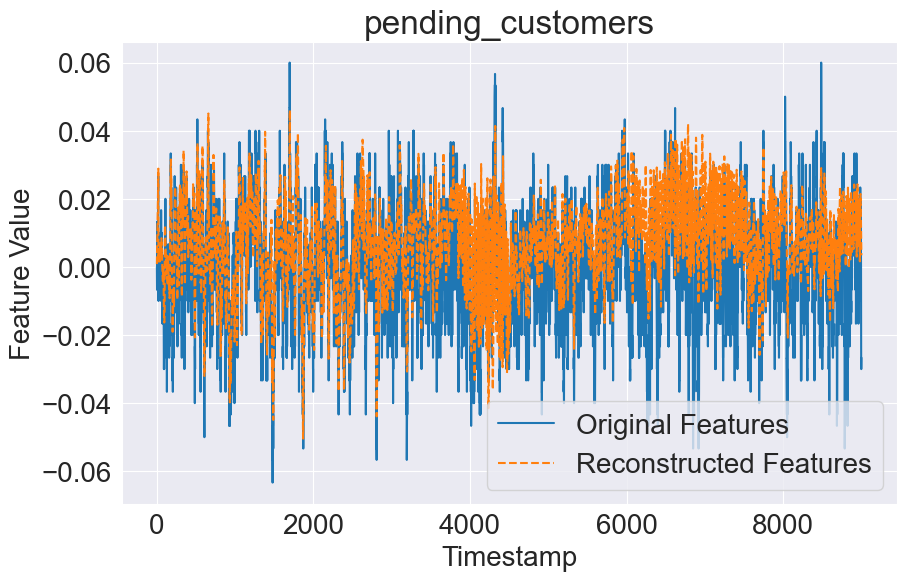

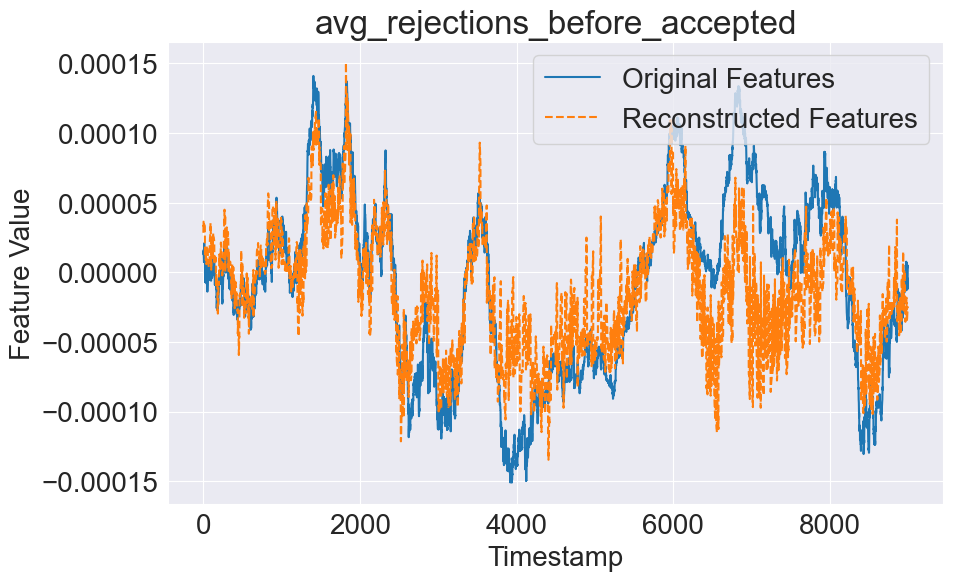

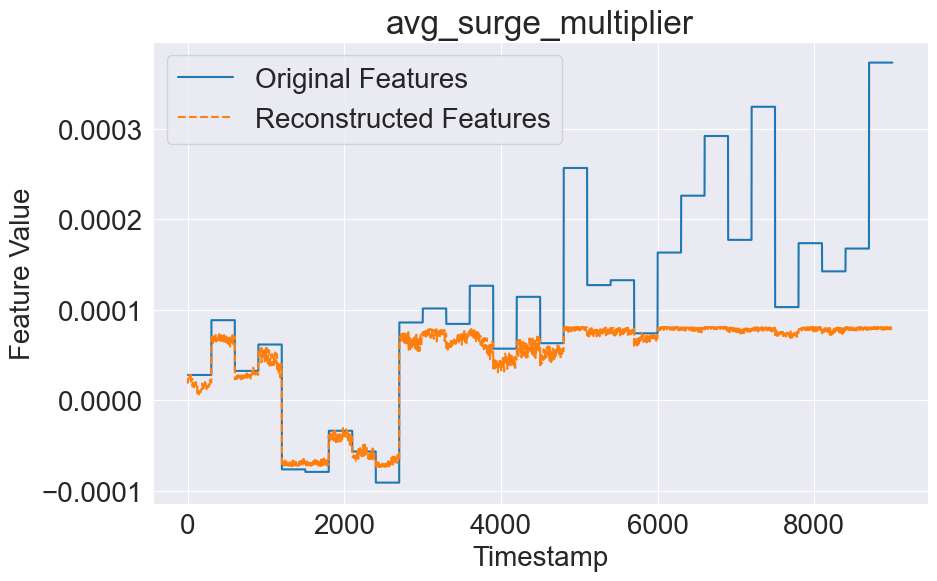

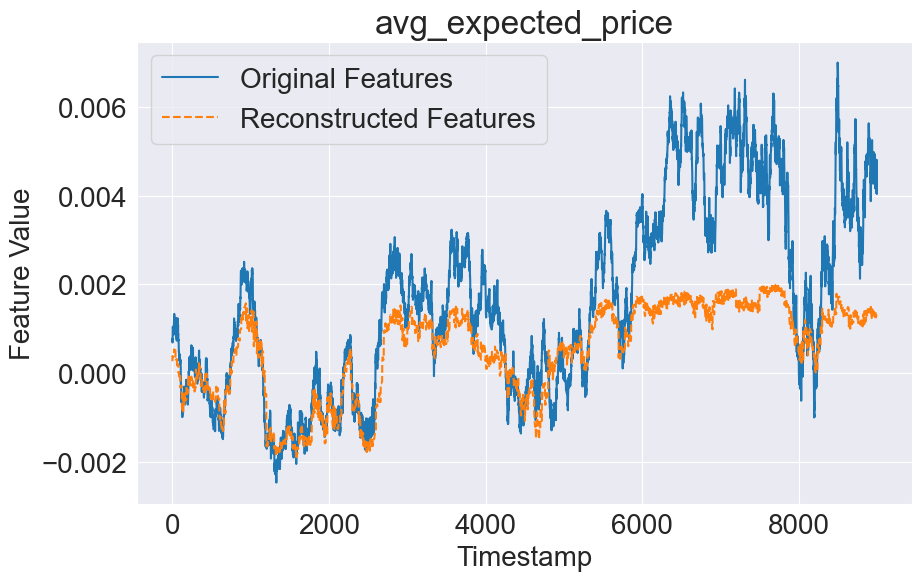

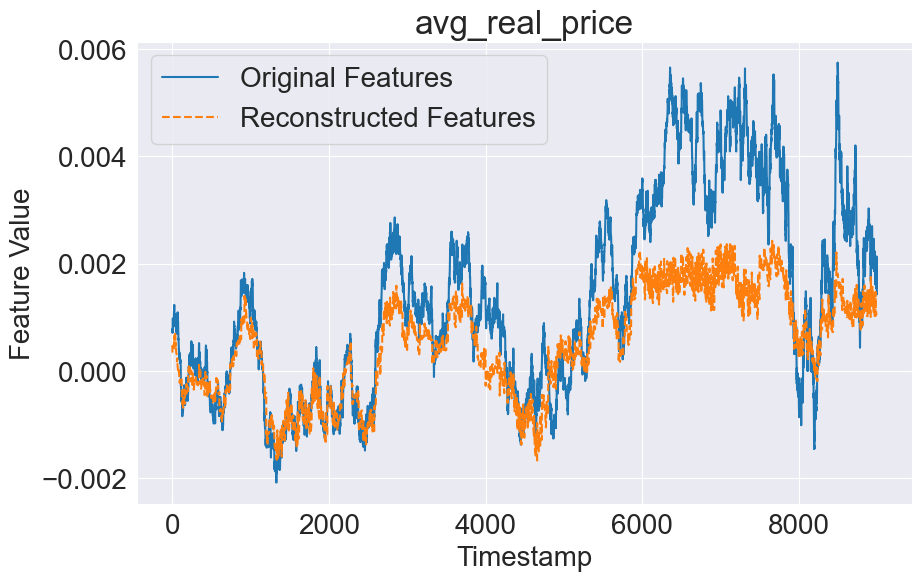

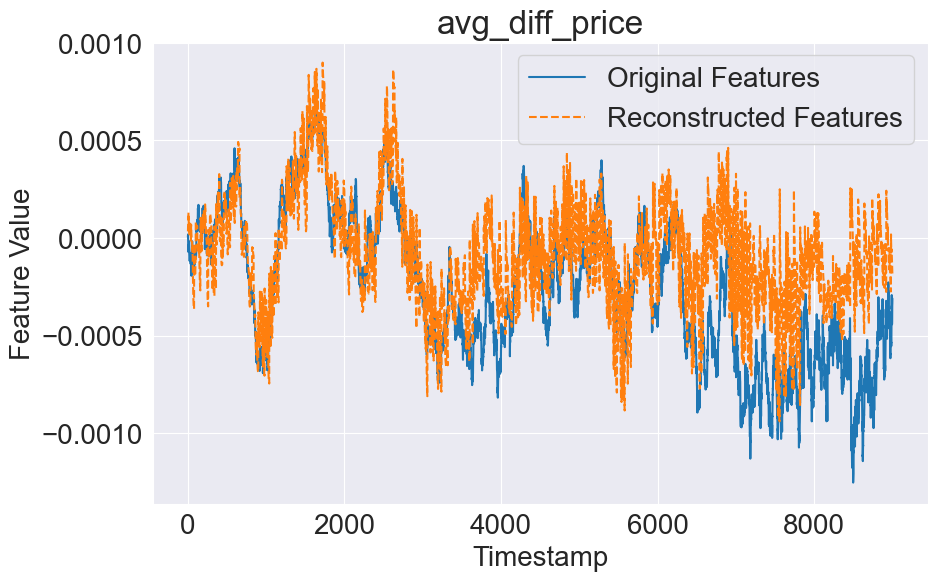

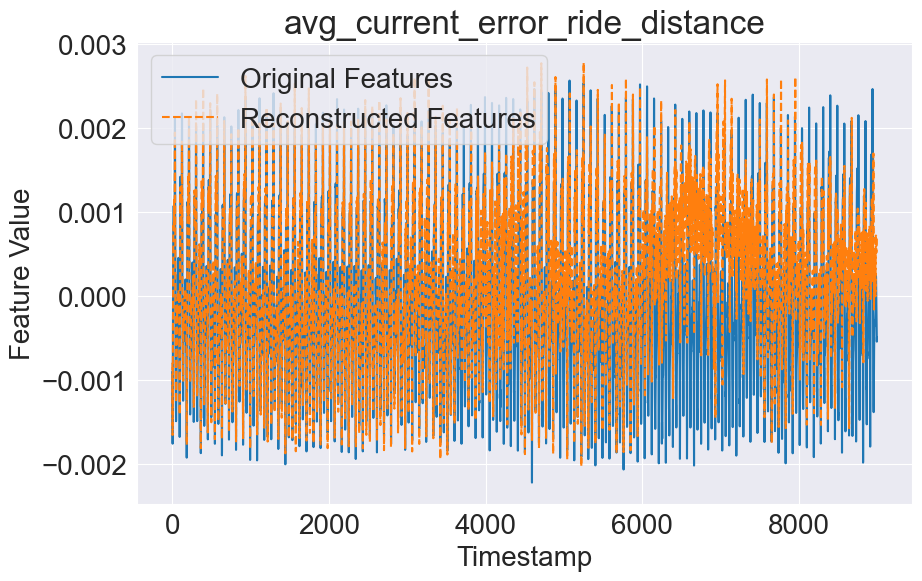

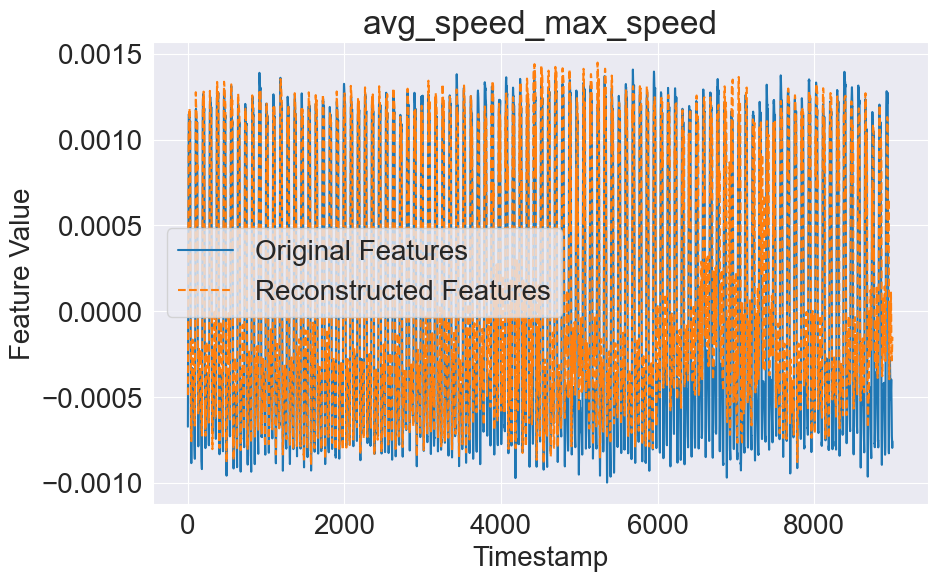

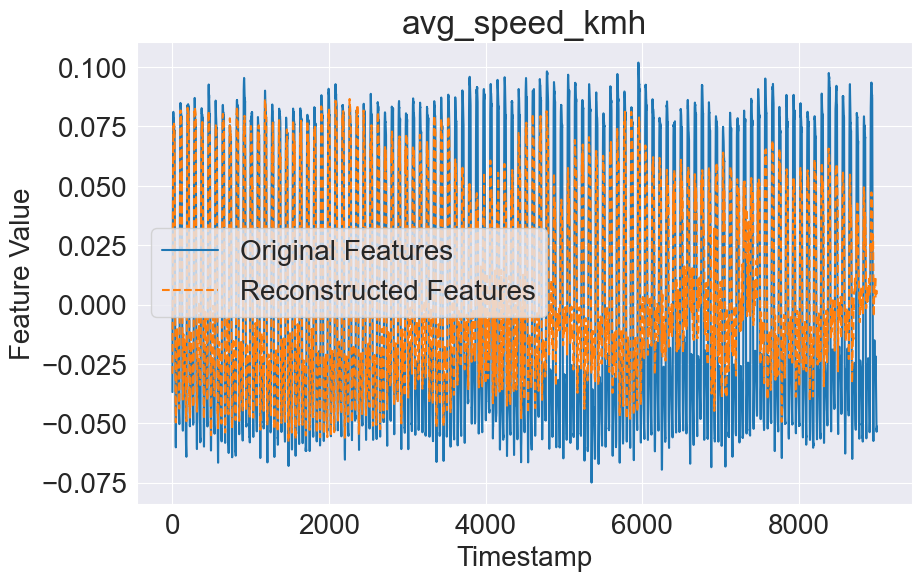

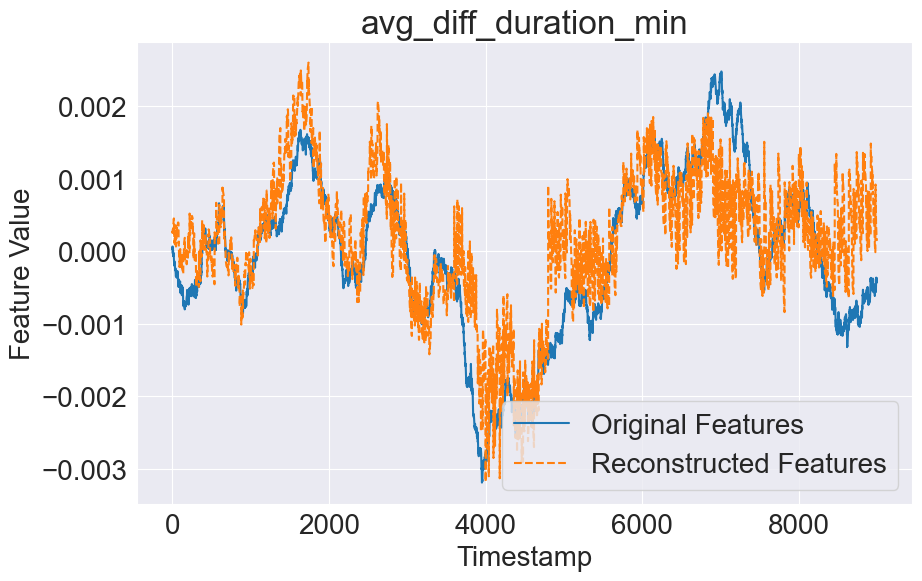

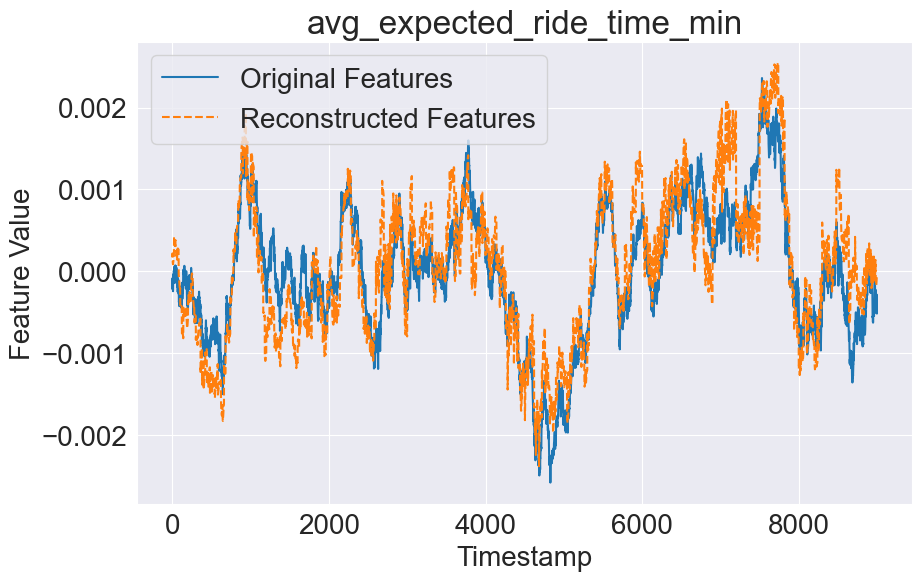

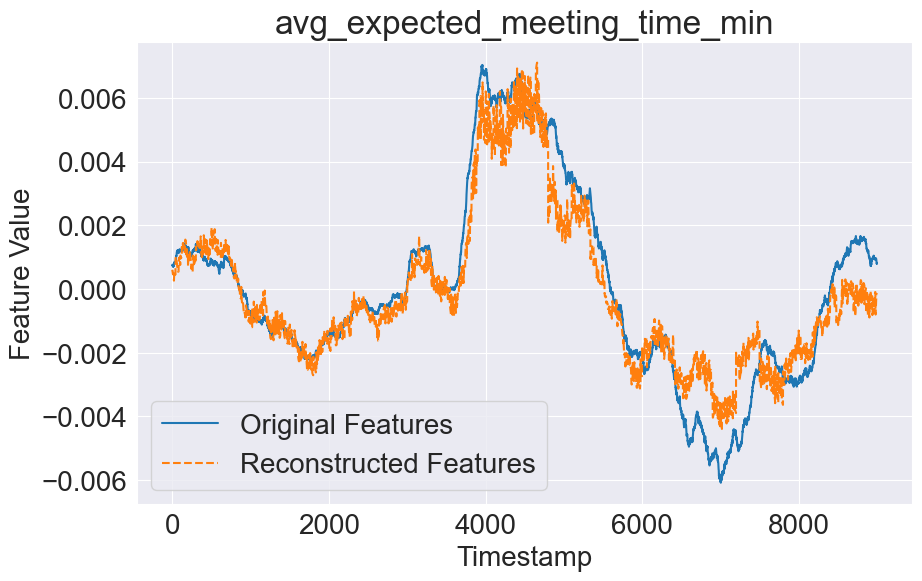

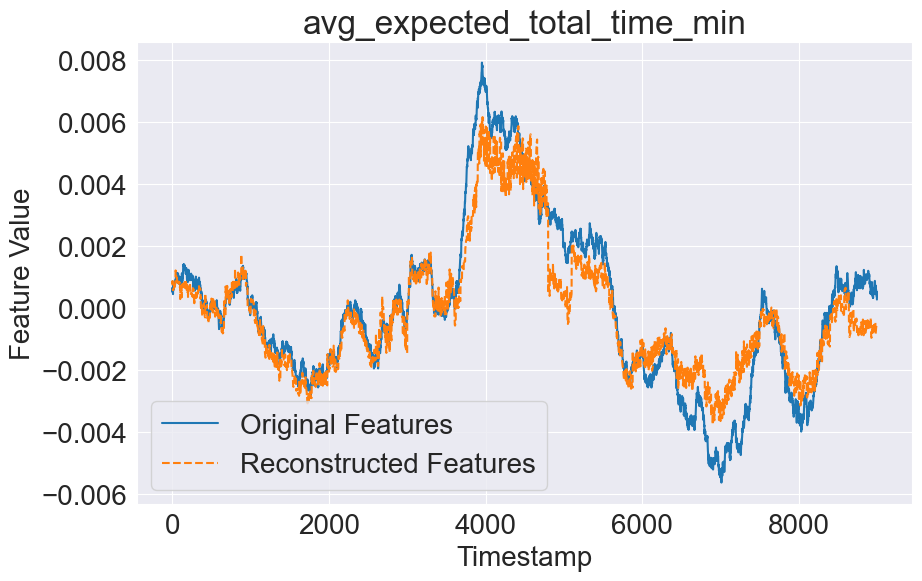

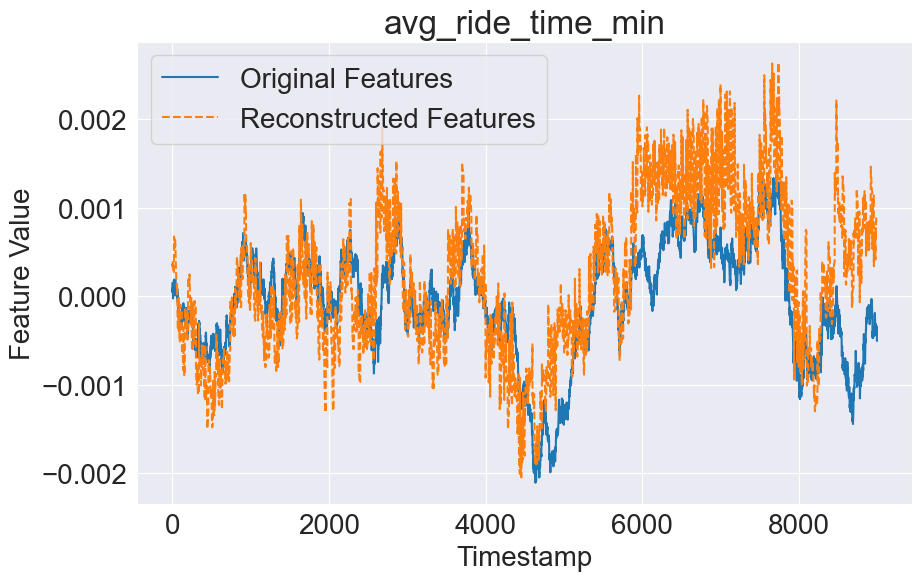

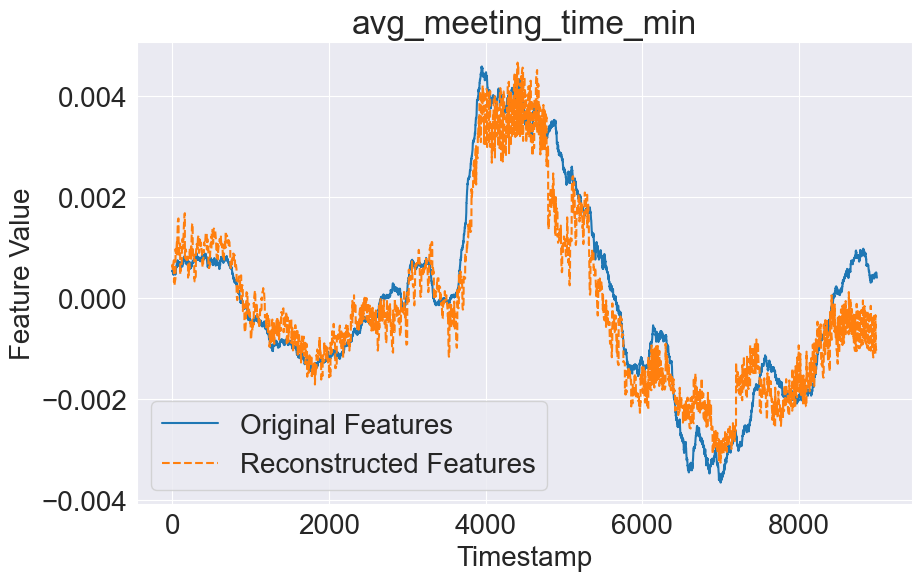

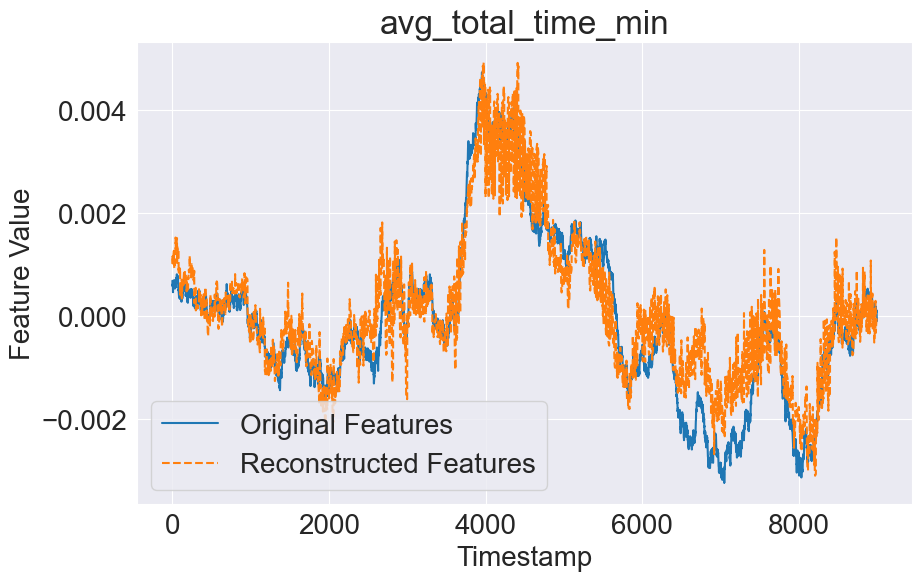

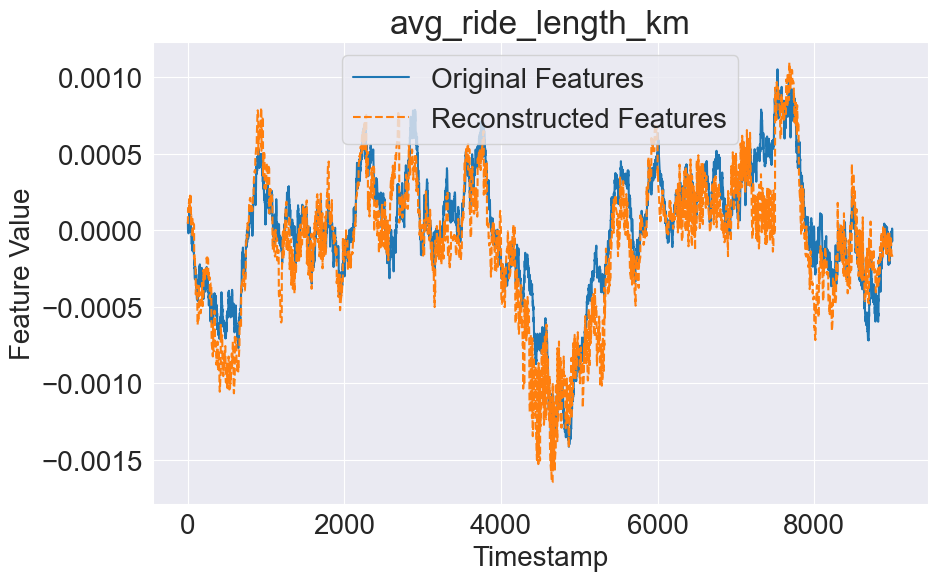

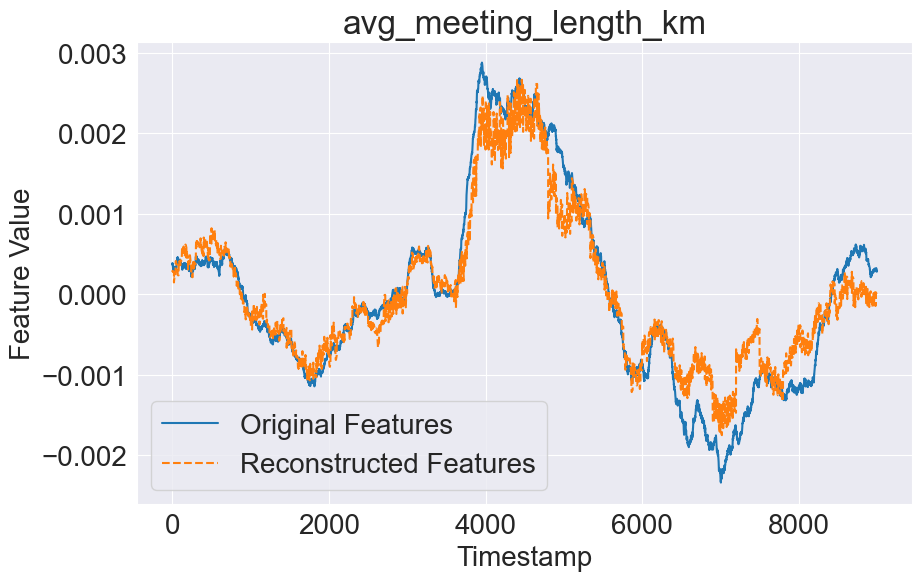

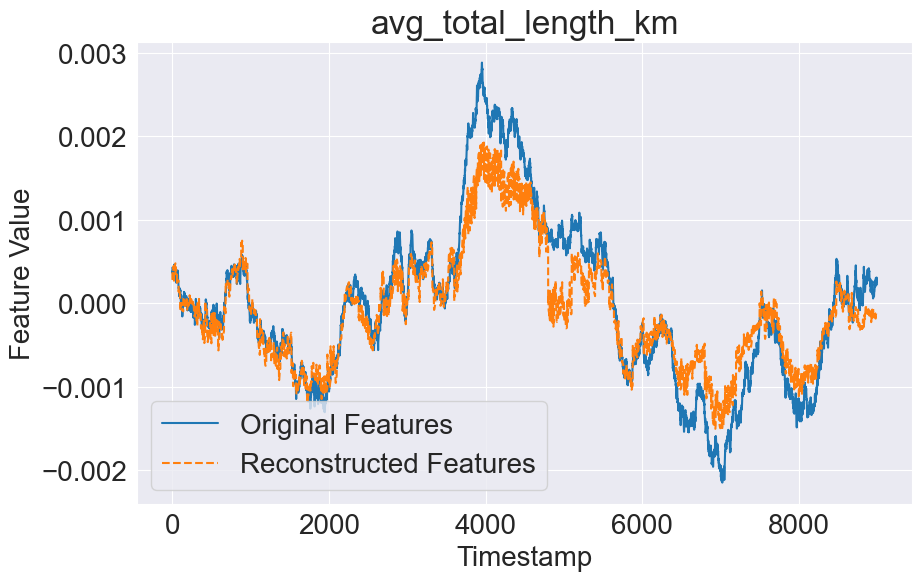

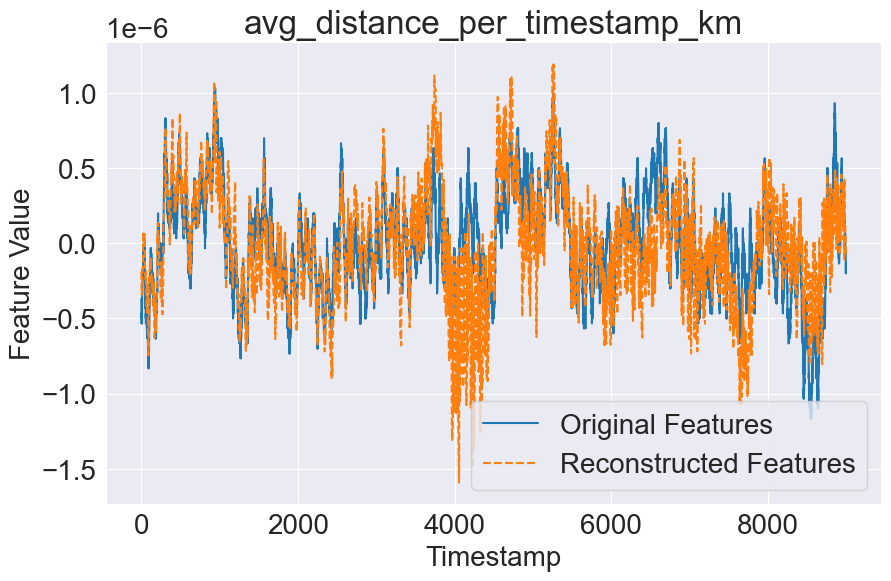

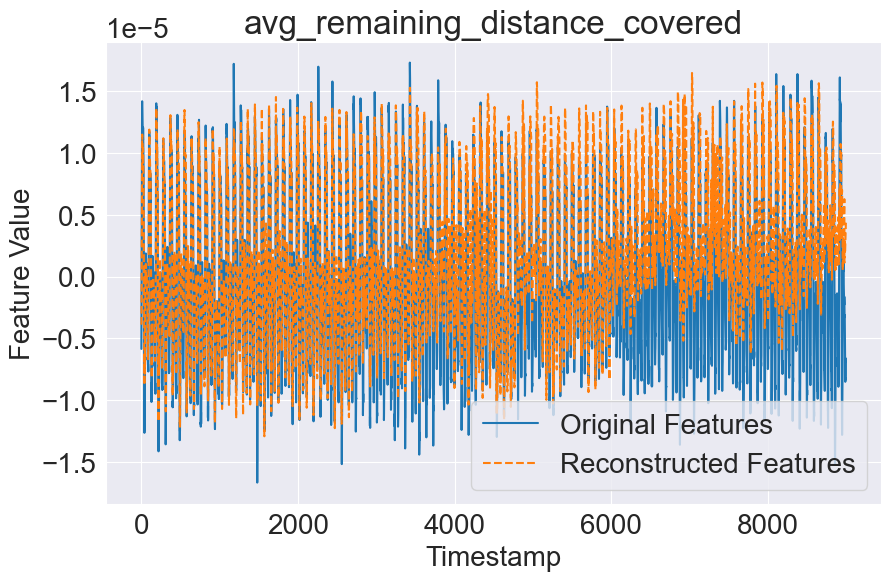

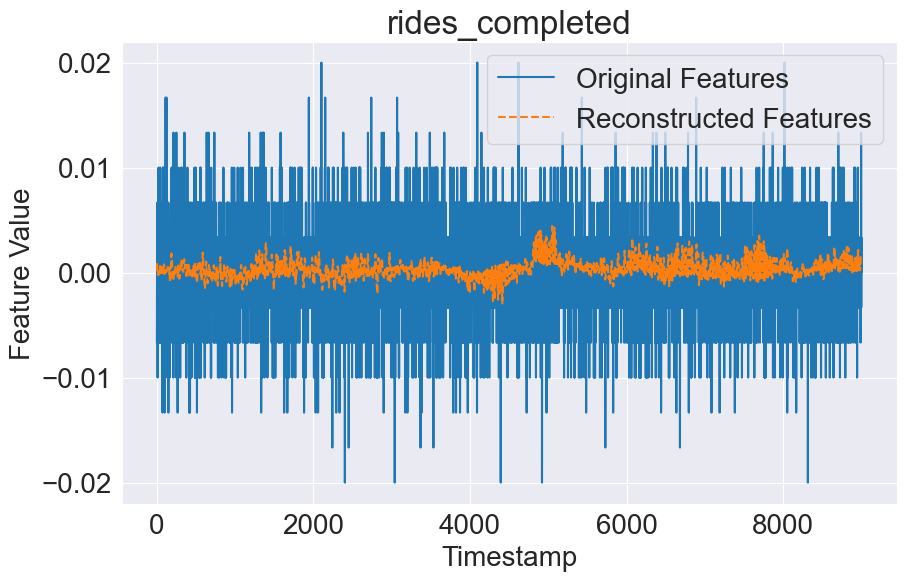

In [65]:
# Predict and assess performance on test set
original, reconstructed = predict(model, test_set_fail, scaler_path, recurrent = True)

# Save metrics plots and dataframes
num_features = min(test_set_fail.shape[2], len(df_proc_fail.columns))
mae, mse, mape = save_predict_plots(original, reconstructed, df_proc_fail.columns, num_features, scaler_path, model_type = 'lstm_fail', plot = False, compute_df = True)

# Plot test set reconstruction performance
for column in range(0, len(df_proc.columns)):
    plt.figure(figsize = (10, 6))
    plt.plot(original[1800:, column], label = 'Original Features')
    plt.plot(reconstructed[1800:, column], label = 'Reconstructed Features', linestyle = '--')
    plt.title(df_proc.columns[column])
    plt.xlabel("Timestamp")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

## Overall anomaly

We compute the overall performance across all the indicators, by taking the normalized mean of the reconstruction error across all columns.

In [66]:
# Load metrics datasets
mae_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mae.csv")[1800:]
mae_fail_df = mae_fail_df.dropna().reset_index(drop = True)
mse_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mse.csv")[1800:]
mse_fail_df = mse_fail_df.dropna().reset_index(drop = True)
mape_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mape.csv")[1800:]
mape_fail_df = mape_fail_df.dropna().reset_index(drop = True)

rides_in_progress: 1.0356016227271088
idle_drivers: 2.269302107612999
responding_drivers: 1.0843308892853585
pickup_drivers: 1.2933783842518476
on_road_drivers: 1.1090455367003866
moving_drivers: 2.2148960621081124
pending_customers: 1.2253875968502776
avg_rejections_before_accepted: 1.4294739831092418
avg_surge_multiplier: 8.619458050608346
avg_expected_price: 3.9821883775349454
avg_real_price: 3.4757044021098737
avg_diff_price: 1.3498671712999142
avg_current_error_ride_distance: 1.741684396888328
avg_speed_max_speed: 2.4481478093806364
avg_speed_kmh: 1.959552251732825
avg_diff_duration_min: 0.9094915279680763
avg_expected_ride_time_min: 1.049065321954727
avg_expected_meeting_time_min: 1.418742004527947
avg_expected_total_time_min: 1.3214633417246466
avg_ride_time_min: 0.8846354124285698
avg_meeting_time_min: 1.375078962278532
avg_total_time_min: 0.9107220168462759
avg_ride_length_km: 1.1595684891351752
avg_meeting_length_km: 1.1424025427227302
avg_total_length_km: 1.4800699475139427


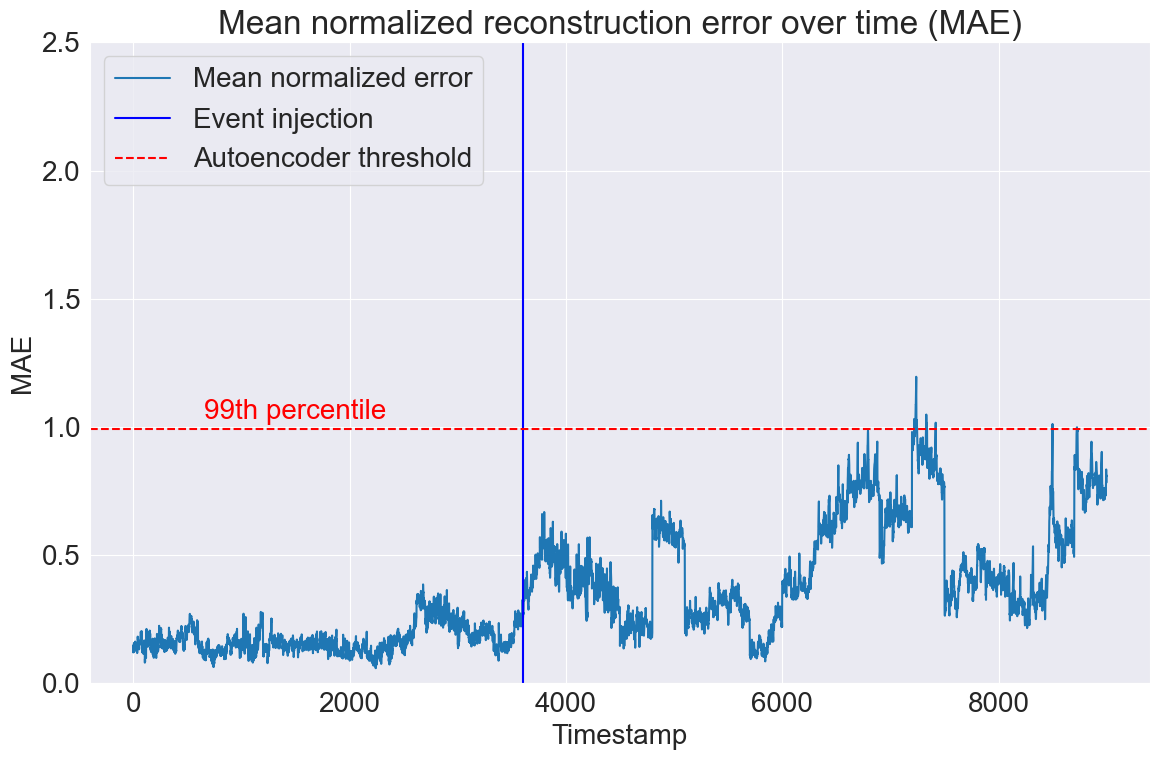

In [67]:
# Plot final results (MAE)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 20})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
detect_time = 60
confidence = 0.95

for indicator in mae_df.columns:
    errors = mae_df[indicator]
    errors_fail = mae_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    print(indicator + ': ' + str(max(normalized_errors)))
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/' + fail + '_' + hour + '_MAE_lstm.csv', index = False)

# Find timestamps where autoencoder error is > 0.99 for more consecutive timestamps
exceeding_timestamp = compute_failure(mean_normalized_errors['mean_error'], 0.99, detect_time, confidence)

plt.figure()
if w_perc_99 != 0:
    x_range = np.arange(len(mean_normalized_errors['mean_error']))
    masked_normalized_errors = np.where(x_range <= w_perc_99, mean_normalized_errors['mean_error'], np.nan)
    plt.plot(x_range, masked_normalized_errors, label = 'Mean normalized error')
else:
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = 0.99, color = 'red', linestyle = '--', label = 'Autoencoder threshold')
if exceeding_timestamp:
    plt.axvline(x=exceeding_timestamp, color='green', linestyle='-', label='Failure detection')
    before = w_perc_99 - exceeding_timestamp
    after = exceeding_timestamp - 3600
plt.annotate(f'99th percentile', xy = (1500, 1.03), xytext = (1500, 1.03),
             horizontalalignment = 'center', color = 'r')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
plt.ylim(0, 2.5)
plt.xlim(-400, 9400)
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='SES failure')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()
if exceeding_timestamp:
    print(f"Failure detected {after} seconds after injection and {before} seconds before crash.")

In [ ]:
# Plot final results (MSE)
'''
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mse_fail_df.index)
normalized_thresholds_99 = []

for indicator in mse_df.columns:
    errors = mse_df[indicator]
    errors_fail = mse_fail_df[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    print(indicator + ': ' + str(max(normalized_errors)))
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/' + fail + '_' + hour + '_MSE_lstm.csv', index = False)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MSE)')
plt.xlabel('Timestamp')
plt.ylabel('MSE')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='99th Perc (W)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MSE_lstm.png', dpi = 300)
plt.show()
'''

In [ ]:
# Plot final results (MAPE)
'''
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mape_fail_df.index)
normalized_thresholds_99 = []

for indicator in mape_df.columns:
    errors = mape_df[indicator]
    errors_fail = mape_fail_df[indicator]
    
    # Normalize errors  wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    print(indicator + ': ' + str(max(normalized_errors)))

mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/' + fail + '_' + hour + '_MAPE_lstm.csv', index = False)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAPE)')
plt.xlabel('Timestamp')
plt.ylabel('MAPE')
if perc_95 != 0:
    plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
if perc_97 != 0:
    plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
if perc_99 != 0:
    plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
if w_perc_95 != 0:
    plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
if w_perc_97 != 0:
    plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='99th Perc (W)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/' + fail + '_' + hour + '_MAPE_lstm.png', dpi = 300)
plt.show()
'''

## Clustering indicators

Now we apply three different filters, using three disjoint subsets of indicators concerning three different aspects of our Smart EcoSystem: **system**, **environment** and **people**.

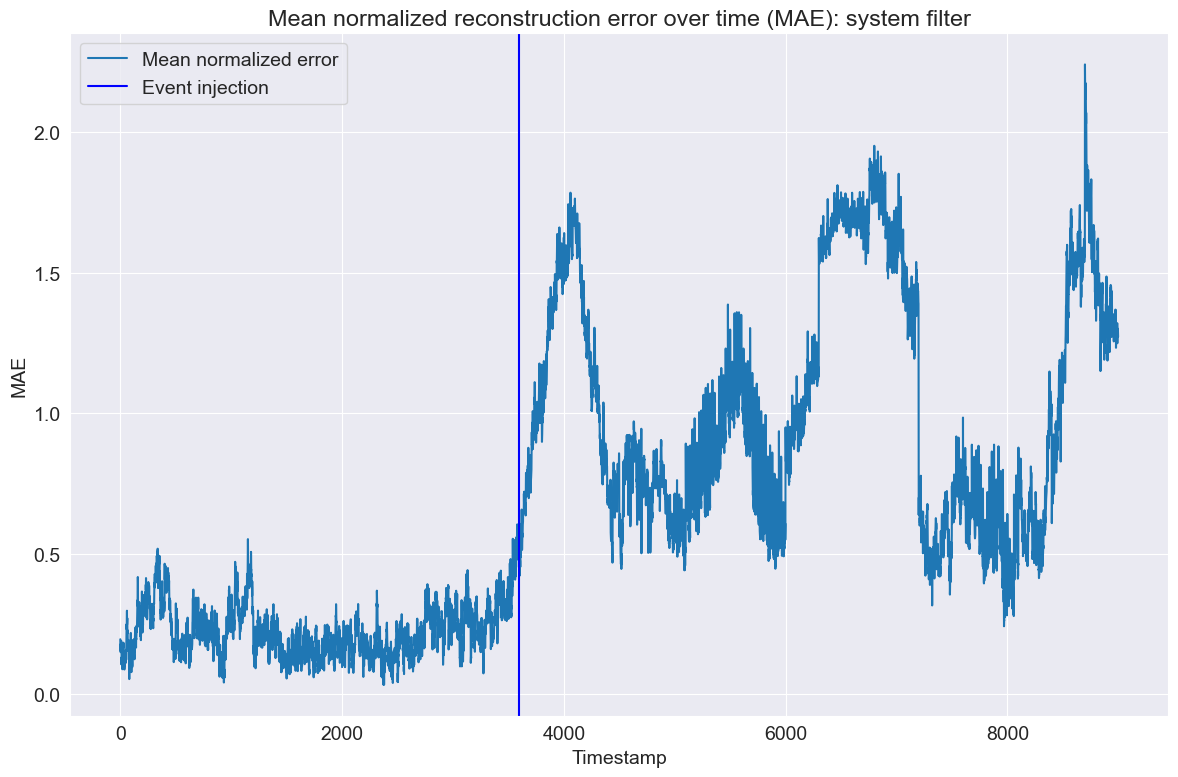

In [204]:
# System filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
system_columns = ['rides_in_progress', 'rides_completed', 'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price', 'avg_diff_price']

mae_df_system = mae_df[system_columns]
mae_fail_df_system = mae_fail_df[system_columns]

for indicator in mae_df_system.columns:
    errors = mae_df_system[indicator]
    errors_fail = mae_fail_df_system[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/filters/system_' + fail + '_' + hour + '_MAE_lstm.csv', index = False)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): system filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='99th Perc (W)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/system_' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

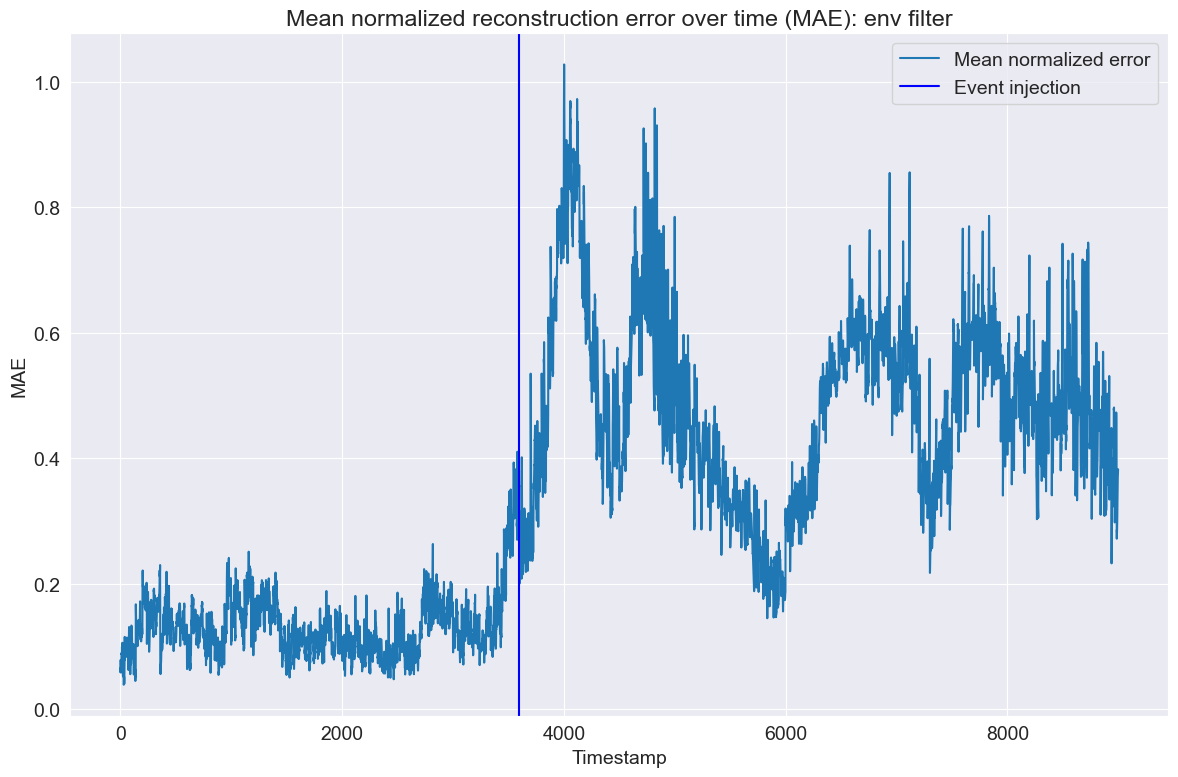

In [205]:
# Environment filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
env_columns = ['avg_current_error_ride_distance', 'avg_speed_max_speed', 'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min', 'avg_expected_meeting_time_min', 'avg_expected_total_time_min', 'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min', 'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km', 'avg_distance_per_timestamp_km', 'avg_remaining_distance_covered']

mae_df_env = mae_df[env_columns]
mae_fail_df_env = mae_fail_df[env_columns]

for indicator in mae_df_env.columns:
    errors = mae_df_env[indicator]
    errors_fail = mae_fail_df_env[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/filters/env_' + fail + '_' + hour + '_MAE_lstm.csv', index = False)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): env filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='99th Perc (W)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/env_' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

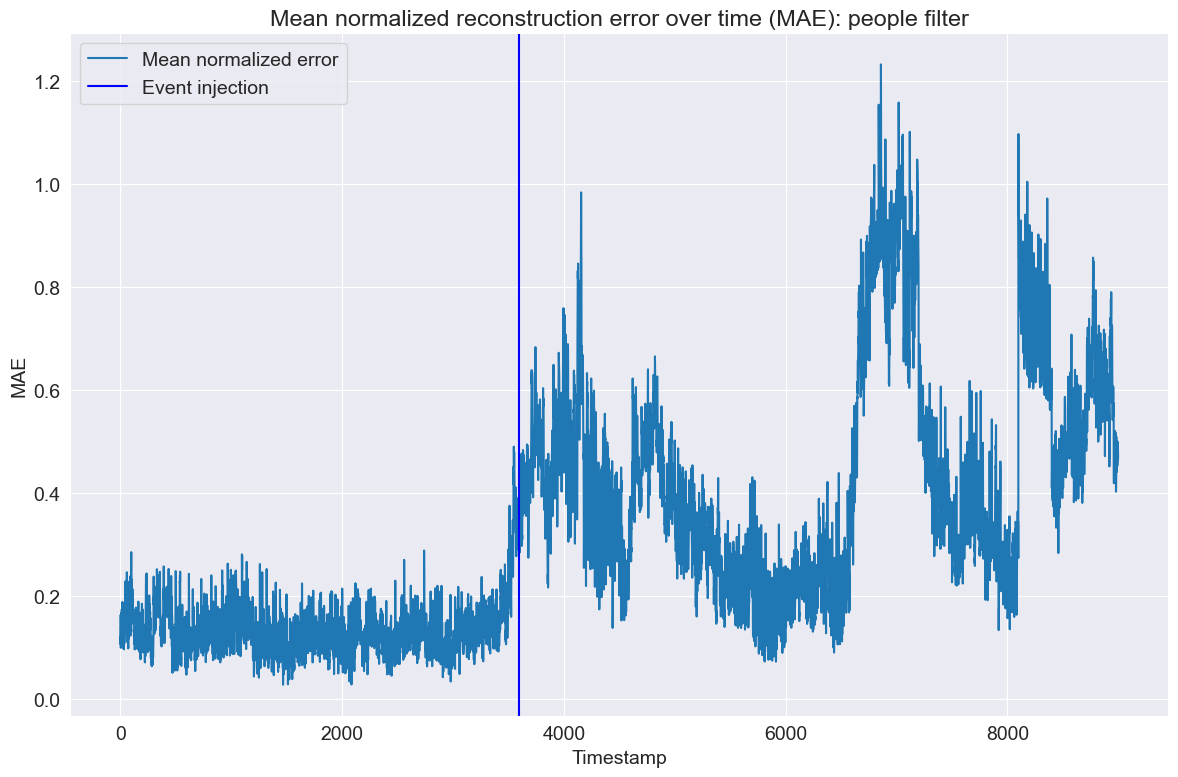

In [206]:
# People filter

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []
people_columns = ['idle_drivers', 'on_road_drivers', 'pickup_drivers', 'responding_drivers', 'pending_customers', 'avg_rejections_before_accepted', 'moving_drivers']

mae_df_people = mae_df[people_columns]
mae_fail_df_people = mae_fail_df[people_columns]

for indicator in mae_df_people.columns:
    errors = mae_df_people[indicator]
    errors_fail = mae_fail_df_people[indicator]
    
    # Normalize errors wrt training errors
    normalized_errors = (errors_fail - min(errors)) / (max(errors) - min(errors))
    mean_normalized_errors[indicator] = normalized_errors
    
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1).reset_index(drop = True)
mean_normalized_errors.to_csv('results/filters/people_' + fail + '_' + hour + '_MAE_lstm.csv', index = False)

plt.figure()
plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): people filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='99th Perc (W)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/filters/people_' + fail + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

# Compare errors

Now we can compare the autoencoder reconstruction errors between the different scenarios.

In [1055]:
event_1 = 'flash_mob'
event_2 = 'flash_mob_greedy'

In [1056]:
mae_res_1 = pd.read_csv('results/' + event_1 + '_' + hour + '_MAE_lstm.csv')
#mse_res_1 = pd.read_csv('results/' + event_1 + '_' + hour + '_MSE_lstm.csv')
#mape_res_1 = pd.read_csv('results/' + event_1 + '_' + hour + '_MAPE_lstm.csv')
mae_res_2 = pd.read_csv('results/' + event_2 + '_' + hour + '_MAE_lstm.csv')
#mse_res_2 = pd.read_csv('results/' + event_2 + '_' + hour + '_MSE_lstm.csv')
#mape_res_2 = pd.read_csv('results/' + event_2 + '_' + hour + '_MAPE_lstm.csv')
mae_res_system_1 = pd.read_csv('results/filters/system_' + event_1 + '_' + hour + '_MAE_lstm.csv')
#mse_res_system_1 = pd.read_csv('results/filters/system_' + event_1 + '_' + hour + '_MSE_lstm.csv')
mae_res_system_2 = pd.read_csv('results/filters/system_' + event_2 + '_' + hour + '_MAE_lstm.csv')
#mse_res_system_2 = pd.read_csv('results/filters/system_' + event_2 + '_' + hour + '_MSE_lstm.csv')
mae_res_env_1 = pd.read_csv('results/filters/env_' + event_1 + '_' + hour + '_MAE_lstm.csv')
#mse_res_env_1 = pd.read_csv('results/filters/env_' + event_1 + '_' + hour + '_MSE_lstm.csv')
mae_res_env_2 = pd.read_csv('results/filters/env_' + event_2 + '_' + hour + '_MAE_lstm.csv')
#mse_res_env_2 = pd.read_csv('results/filters/env_' + event_2 + '_' + hour + '_MSE_lstm.csv')
mae_res_people_1 = pd.read_csv('results/filters/people_' + event_1 + '_' + hour + '_MAE_lstm.csv')
#mse_res_people_1 = pd.read_csv('results/filters/people_' + event_1 + '_' + hour + '_MSE_lstm.csv')
mae_res_people_2 = pd.read_csv('results/filters/people_' + event_2 + '_' + hour + '_MAE_lstm.csv')
#mse_res_people_2 = pd.read_csv('results/filters/people_' + event_2 + '_' + hour + '_MSE_lstm.csv')

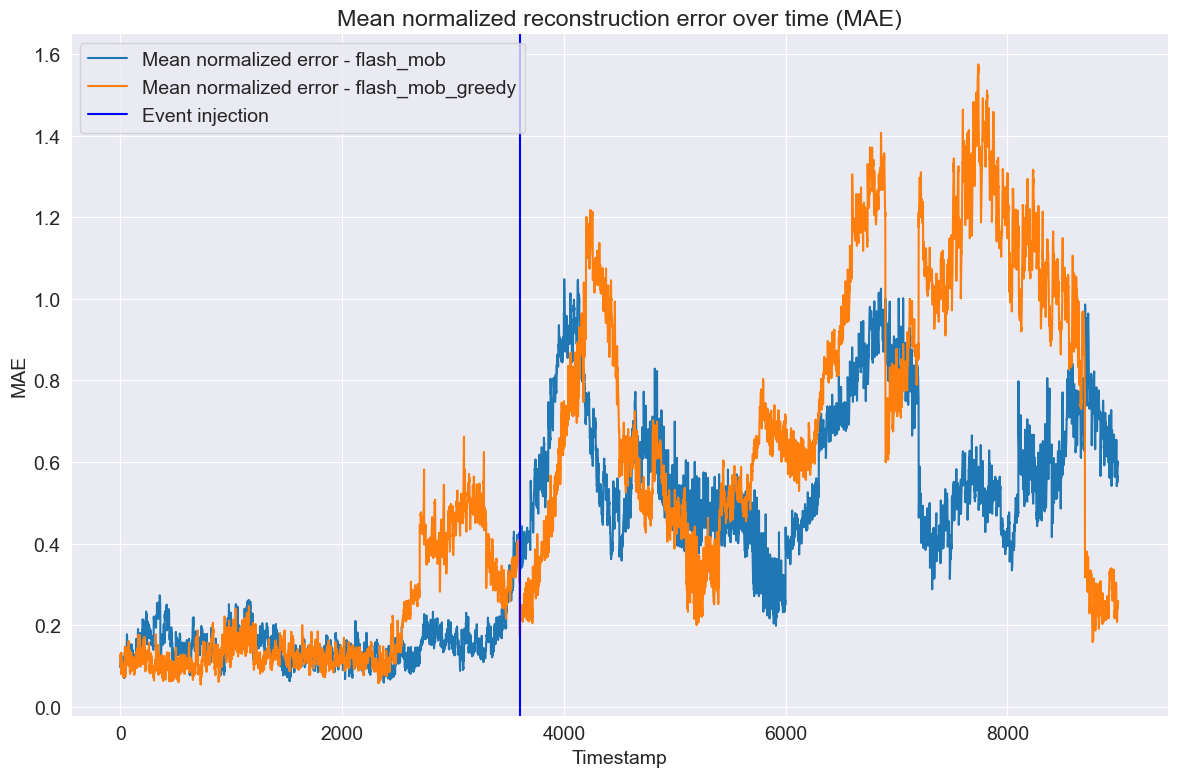

In [1057]:
plt.figure()
plt.plot(mae_res_1.index, mae_res_1['mean_error'], label = 'Mean normalized error - ' + event_1)
plt.plot(mae_res_2.index, mae_res_2['mean_error'], label = 'Mean normalized error - ' + event_2)
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE)')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/comparison/' + event_1 + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

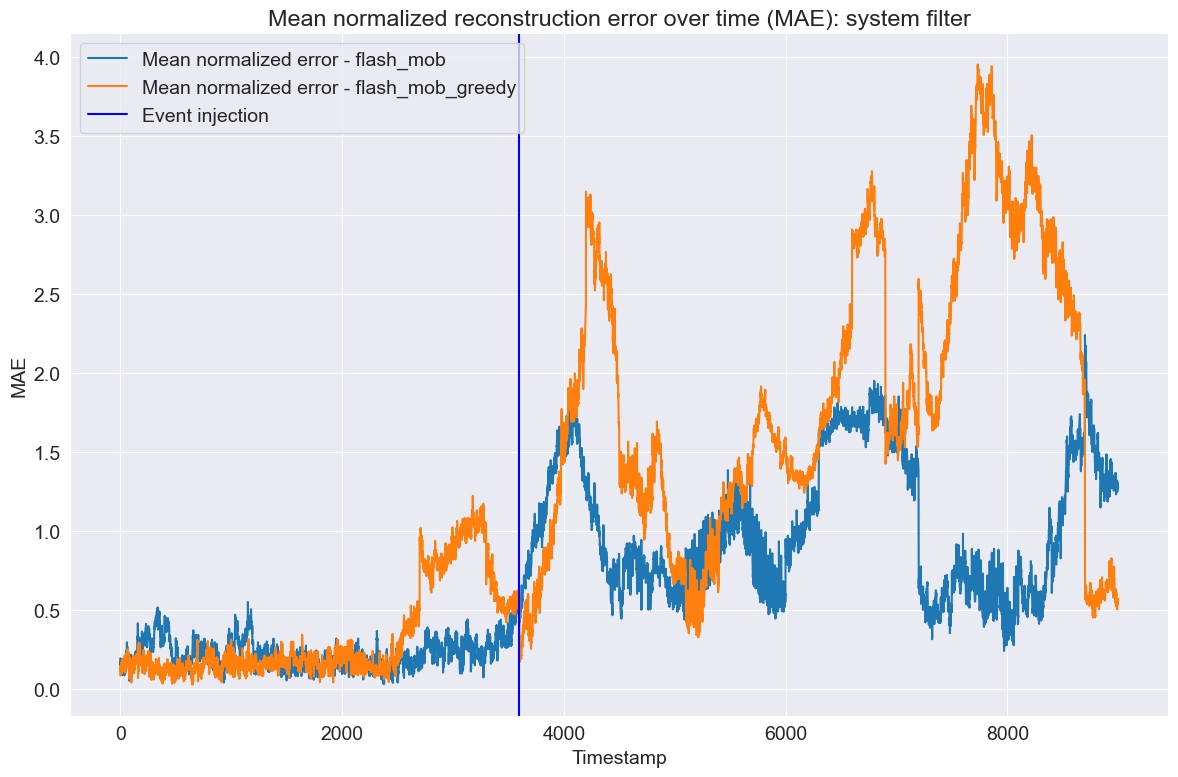

In [1059]:
plt.figure()
plt.plot(mae_res_system_1.index, mae_res_system_1['mean_error'], label = 'Mean normalized error - ' + event_1)
plt.plot(mae_res_system_2.index, mae_res_system_2['mean_error'], label = 'Mean normalized error - ' + event_2)
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): system filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/comparison/system_' + event_1 + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

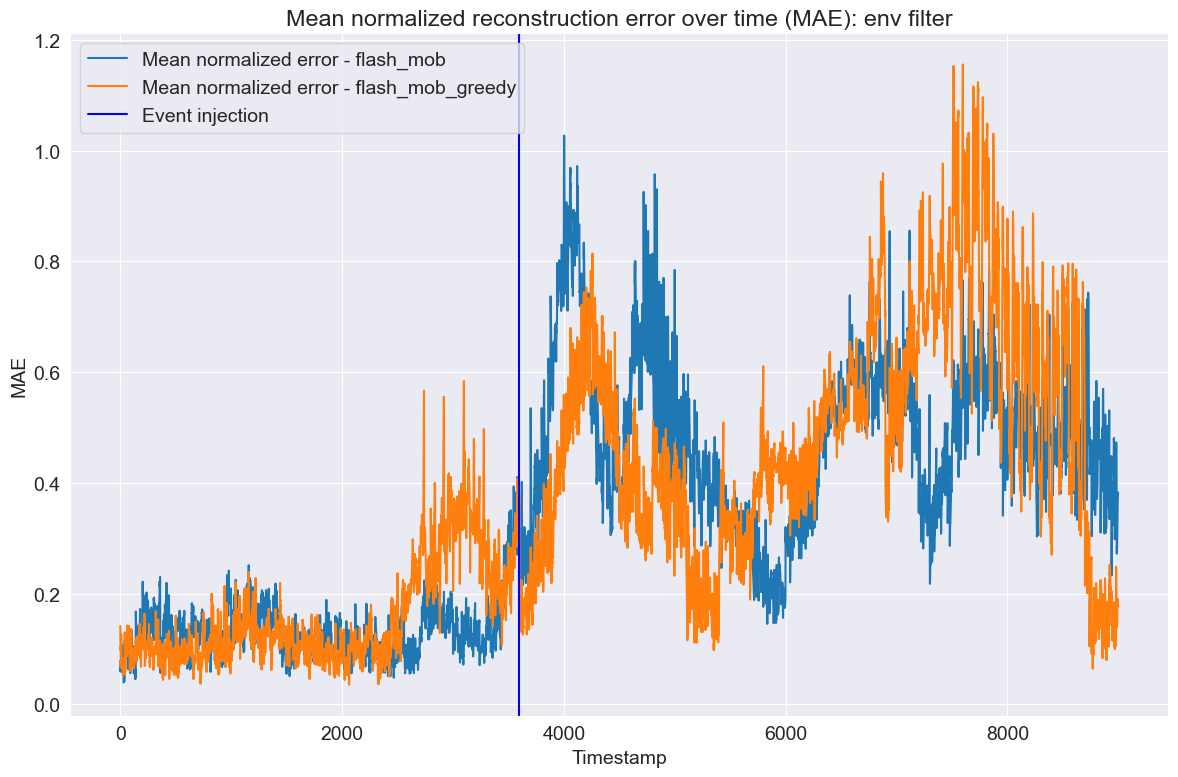

In [1061]:
plt.figure()
plt.plot(mae_res_env_1.index, mae_res_env_1['mean_error'], label = 'Mean normalized error - ' + event_1)
plt.plot(mae_res_env_2.index, mae_res_env_2['mean_error'], label = 'Mean normalized error - ' + event_2)
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): env filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/comparison/env_' + event_1 + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()

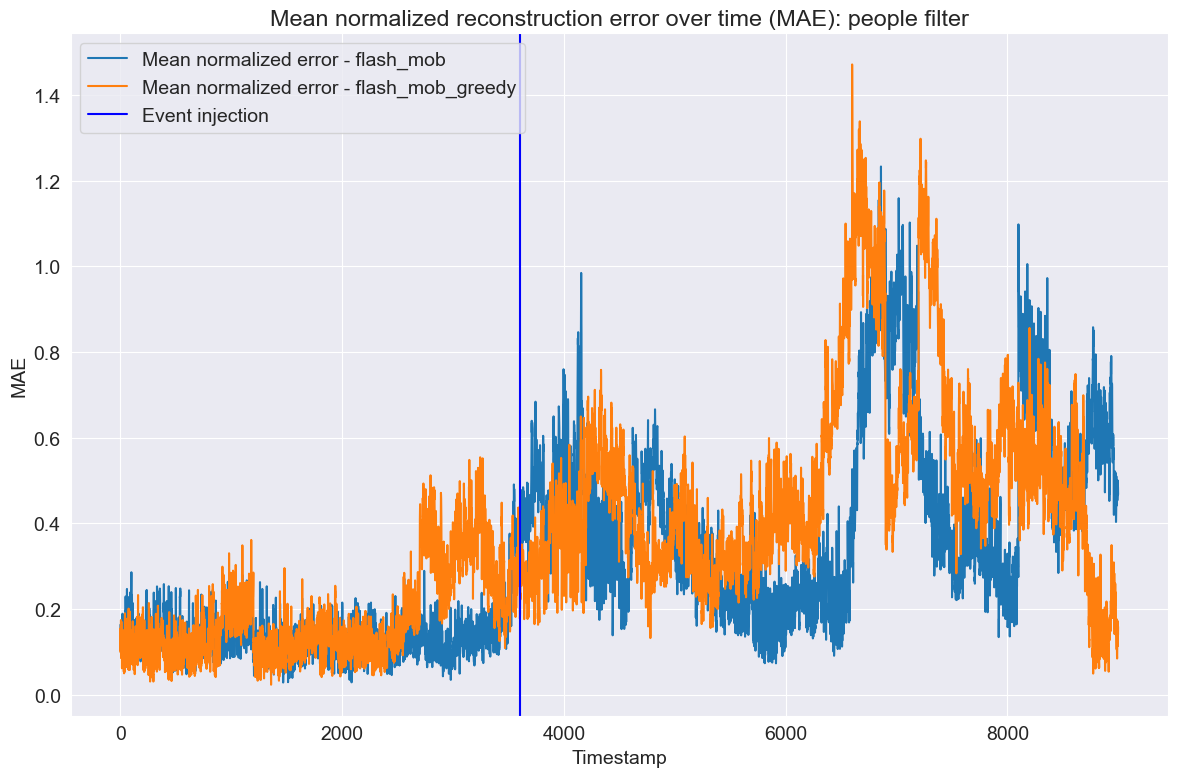

In [1063]:
plt.figure()
plt.plot(mae_res_people_1.index, mae_res_people_1['mean_error'], label = 'Mean normalized error - ' + event_1)
plt.plot(mae_res_people_2.index, mae_res_people_2['mean_error'], label = 'Mean normalized error - ' + event_2)
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.title('Mean normalized reconstruction error over time (MAE): people filter')
plt.xlabel('Timestamp')
plt.ylabel('MAE')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig('results/comparison/people_' + event_1 + '_' + hour + '_MAE_lstm.png', dpi = 300)
plt.show()